# Exploring Dandiset 001375: Septum GABA disruption with DREADDs

## Important Notice

**This notebook was generated using AI and has not been fully verified. Please exercise caution when interpreting the code or results.**

## Overview

This notebook explores Dandiset 001375, "Septum GABA disruption with DREADDs," a pilot study investigating the effects of disrupting septal GABAergic activity using DREADDs (Designer Receptors Exclusively Activated by Designer Drugs) on hippocampal and neocortical activity. The dataset contains neural recordings from mice running laps in a virtual hallway.

Link to the Dandiset: [https://dandiarchive.org/dandiset/001375/0.250406.1855](https://dandiarchive.org/dandiset/001375/0.250406.1855)

The Dandiset contains three NWB (Neurodata Without Borders) files representing recordings from two subjects:

- `sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb`: Recordings from subject MS13B
- `sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb`: First recording from subject MS14A
- `sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb`: Second recording from subject MS14A

## What This Notebook Covers

In this notebook, we will:

1. Connect to the DANDI Archive and retrieve basic information about Dandiset 001375
2. Examine the structure and metadata of the NWB files
3. Load and visualize electrophysiology data from the primary recording electrode
4. Explore the spike times of sorted neural units
5. Analyze trial (lap) data and visualize spike activity during trials
6. Examine the spatial distribution of neural recording locations
7. Visualize correlations between neural activity across different units

## Required Packages

This notebook requires the following Python packages:

```
dandi
pynwb
remfile
h5py
numpy
matplotlib
pandas
seaborn
```

Please ensure these packages are installed before running this notebook.

## Accessing the Dandiset

First, let's connect to the DANDI Archive and retrieve basic information about Dandiset 001375.

In [1]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001375", "0.250406.1855")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset ID: {metadata['identifier']}")
print(f"Version: {metadata['version']}")
print(f"Description: {metadata['description']}")

# Handle contributors which might be dictionaries or strings
contributors = []
for contributor in metadata['contributor']:
    if isinstance(contributor, dict) and 'name' in contributor:
        contributors.append(contributor['name'])
    elif isinstance(contributor, str):
        contributors.append(contributor)
    else:
        contributors.append(str(contributor))
        
print(f"Contributors: {', '.join(contributors)}")

# List assets in the Dandiset
assets = dandiset.get_assets()
print("\nAvailable assets:")
for asset in islice(assets, 3):  # Show all 3 assets
    print(f"- {asset.path} (Size: {asset.size/1e9:.2f} GB)")

Dandiset name: Septum GABA disruption with DREADDs
Dandiset ID: DANDI:001375
Version: 0.250406.1855
Description: Pilot study of the effect of disrupting septal gabaergic activity using DREADDs on hippocampal and neocortical activity
Contributors: Eckert, Michael, NIH Brain, McNaughton, Bruce, Ferbinteanu, Janina

Available assets:
- sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb (Size: 54.97 GB)
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb (Size: 69.45 GB)
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb (Size: 69.79 GB)


## Exploring an NWB File

Now, let's load one of the NWB files from the Dandiset and explore its structure and content. We'll focus on the first file from subject MS13B.

In [2]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Set up the seaborn theme for plots
sns.set_theme()

# Define the URL for the NWB file
asset_id = "ce525828-8534-4b56-9e47-d2a34d1aa897"
url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"
print(f"Loading NWB file from: {url}")

# Load the NWB file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Display basic information about the NWB file
print("\nNWB File Information:")
print(f"Session Description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session Start Time: {nwb.session_start_time}")
print(f"File Creation Date: {nwb.file_create_date[0]}")

Loading NWB file from: https://api.dandiarchive.org/api/assets/ce525828-8534-4b56-9e47-d2a34d1aa897/download/


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."



NWB File Information:
Session Description: mouse running laps in virtual hallway
Identifier: MS13B
Session Start Time: 2024-07-25 19:00:00-07:00
File Creation Date: 2025-04-05 16:50:15.663983-07:00


## Subject Information

Let's examine information about the experimental subject.

In [3]:
# Display information about the subject
print("Subject Information:")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Sex: {nwb.subject.sex}")
print(f"Age: {nwb.subject.age}")
print(f"Description: {nwb.subject.description}")

Subject Information:
Subject ID: MS13B
Species: Mus musculus
Sex: M
Age: P90D
Description: medial septum DREADD to suppress GABA interneurons


## NWB File Structure

The NWB file contains various types of data organized in a hierarchical structure. Here's an overview of the key components:

### Data Structure

- **Acquisition**: Contains raw electrophysiology data as time series
  - `time_series`: Continuous voltage recordings from 256 electrodes

- **Units**: Contains spike times for 33 sorted neural units
  - Each unit has an associated `spike_times` array

- **Electrode Groups**: Contains information about electrode groups
  - `shank1`: First electrode group with 128 channels
  - `shank2`: Second electrode group with 128 channels

- **Electrodes**: Table containing information about all 256 electrodes
  - Includes location, filtering, group, label information

- **Trials**: Contains start and stop times for 387 behavioral trials (laps)

- **Devices**: Contains information about recording devices
  - `silicon probe array`: 128-channel silicon probe

This structure allows for comprehensive analysis of neural activity during the experimental paradigm.

Let's explore some of these components in more detail.

## Trials Information

Let's examine the trials data, which represents the start and stop times of each lap the mouse ran in the virtual hallway.

Number of trials: 387

First 5 trials:
    start_time  stop_time
id                       
0     4.323800  16.929833
1    16.963067  28.414333
2    28.447100  39.402833
3    39.435833  50.027033
4    50.059667  63.064467


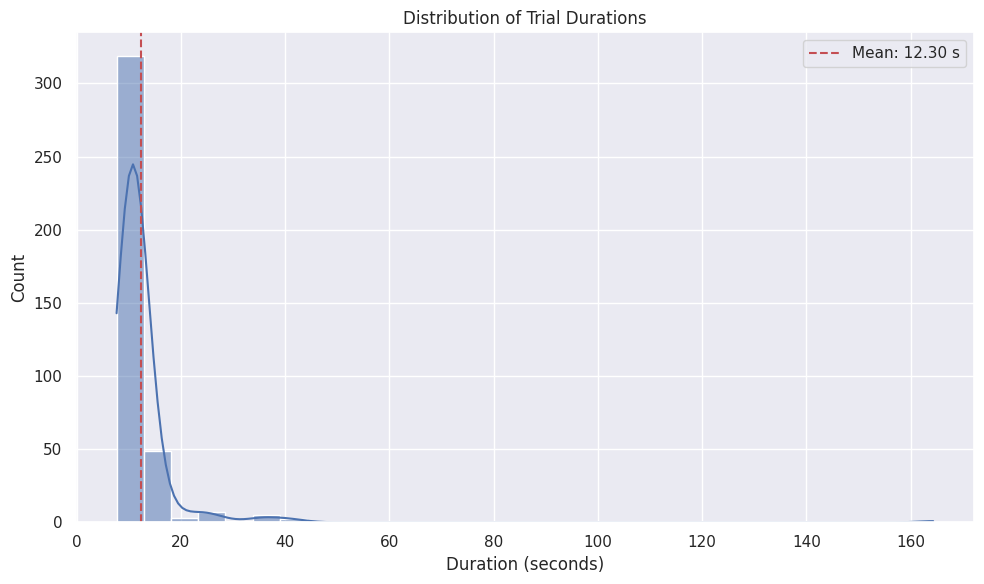

In [4]:
# Convert trials to a pandas DataFrame for easier analysis
trials_df = nwb.trials.to_dataframe()

# Display the first few trials
print(f"Number of trials: {len(trials_df)}")
print("\nFirst 5 trials:")
print(trials_df.head())

# Calculate trial durations
trials_df['duration'] = trials_df['stop_time'] - trials_df['start_time']

# Plot histogram of trial durations
plt.figure(figsize=(10, 6))
sns.histplot(trials_df['duration'], bins=30, kde=True)
plt.title('Distribution of Trial Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.axvline(x=trials_df['duration'].mean(), color='r', linestyle='--', 
            label=f'Mean: {trials_df["duration"].mean():.2f} s')
plt.legend()
plt.tight_layout()

## Electrode Information

Now, let's examine the electrode information to understand the recording setup.

Number of electrodes: 256

Electrode groups:
group_name
shank1    128
shank2    128
Name: count, dtype: int64

First 5 electrodes:
       x       y location        filtering  \
id                                           
0   20.0  1375.0  unknown  0.1 - 7500.0 Hz   
1   20.0  1325.0  unknown  0.1 - 7500.0 Hz   
2   20.0  1275.0  unknown  0.1 - 7500.0 Hz   
3   20.0  1225.0  unknown  0.1 - 7500.0 Hz   
4   20.0  1175.0  unknown  0.1 - 7500.0 Hz   

                                                group group_name  \
id                                                                 
0   shank1 pynwb.ecephys.ElectrodeGroup at 0x12668...     shank1   
1   shank1 pynwb.ecephys.ElectrodeGroup at 0x12668...     shank1   
2   shank1 pynwb.ecephys.ElectrodeGroup at 0x12668...     shank1   
3   shank1 pynwb.ecephys.ElectrodeGroup at 0x12668...     shank1   
4   shank1 pynwb.ecephys.ElectrodeGroup at 0x12668...     shank1   

                  label  
id                       
0   shank1-electr

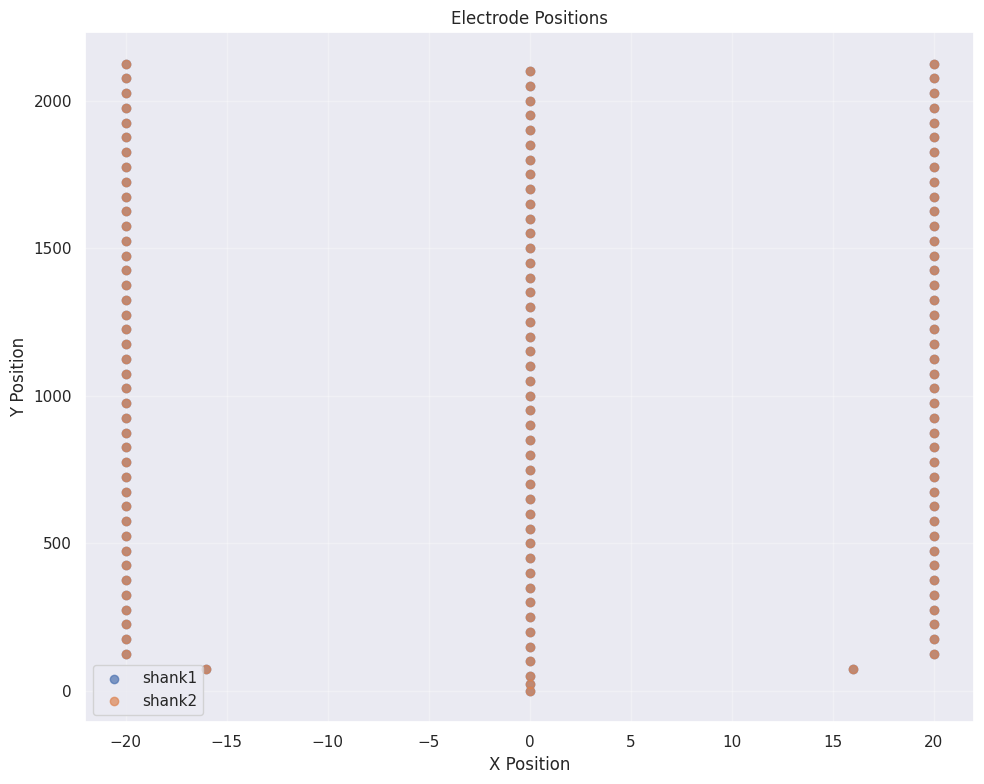

In [5]:
# Convert electrodes to a pandas DataFrame
electrodes_df = nwb.electrodes.to_dataframe()

# Display basic information
print(f"Number of electrodes: {len(electrodes_df)}")
print("\nElectrode groups:")
print(electrodes_df['group_name'].value_counts())

# Display the first few electrodes
print("\nFirst 5 electrodes:")
print(electrodes_df.head())

# Get unique locations
print("\nRecording locations:")
print(electrodes_df['location'].unique())

# Plot electrode positions
plt.figure(figsize=(10, 8))
for group_name, group_df in electrodes_df.groupby('group_name'):
    plt.scatter(group_df['x'], group_df['y'], label=group_name, alpha=0.7)

plt.title('Electrode Positions')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Examining Raw Electrophysiology Data

Now let's examine the raw electrophysiology data. Due to the large size of the dataset (it contains recording from 256 channels at 30 kHz), we'll load only a small subset of the data.

Time Series Information:
Sampling Rate: 30000.0 Hz
Number of Channels: 256
Data Shape: (144675584, 256)
Unit: mV
Duration: 4822.52 seconds


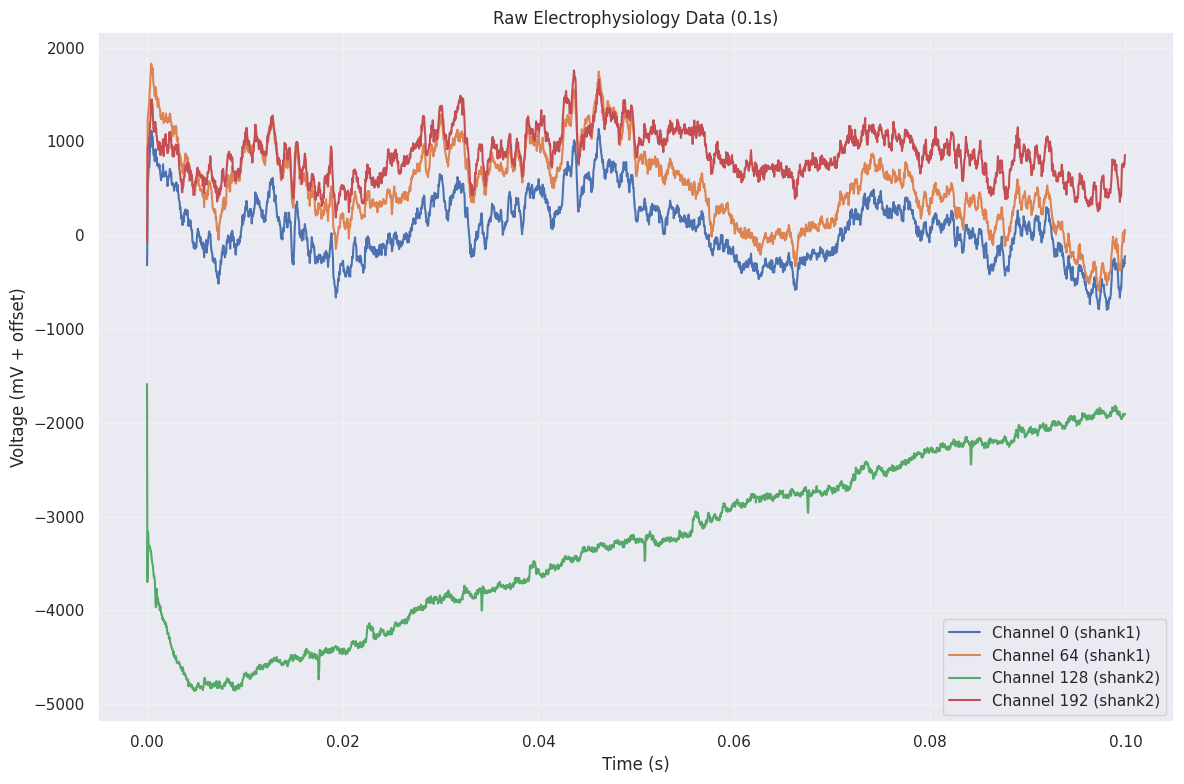

In [6]:
# Get information about the time series data
time_series = nwb.acquisition['time_series']
print("Time Series Information:")
print(f"Sampling Rate: {time_series.rate} Hz")
print(f"Number of Channels: {time_series.data.shape[1]}")
print(f"Data Shape: {time_series.data.shape}")
print(f"Unit: {time_series.unit}")
print(f"Duration: {time_series.data.shape[0]/time_series.rate:.2f} seconds")

# Load a small subset of data (0.1 seconds) from 4 channels
# We'll select 2 channels from each shank
duration = 0.1  # seconds
samples_to_load = int(duration * time_series.rate)
channel_indices = [0, 64, 128, 192]  # Sample from different parts of the probe

# Load the data subset
data_subset = time_series.data[0:samples_to_load, channel_indices]
time_vector = np.arange(samples_to_load) / time_series.rate

# Plot the data
plt.figure(figsize=(12, 8))
for i, channel_idx in enumerate(channel_indices):
    # Get electrode information for this channel
    electrode_info = electrodes_df.iloc[channel_idx]
    label = f"Channel {channel_idx} ({electrode_info['group_name']})"
    
    # Plot with offset for visibility
    plt.plot(time_vector, data_subset[:, i] + i*200, label=label)

plt.title('Raw Electrophysiology Data (0.1s)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV + offset)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Exploring Spike Data

Let's examine the spike times of the sorted neural units.

Number of units: 33
Unit columns: ('spike_times',)



Units with the most spikes:
   unit_id  spike_count
0        2       278061
1        9       214826
2       15       154373
3        8       154188
4        7       122980
5        1       100435
6       11        96504
7       23        87167
8        5        86118
9       32        84315


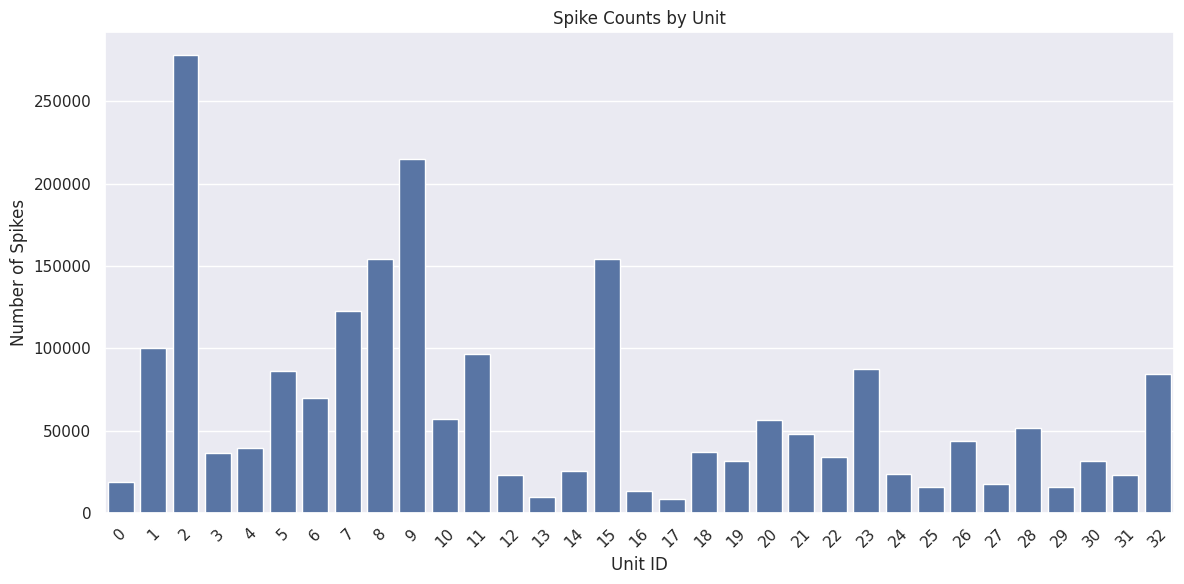

In [7]:
# Get basic information about units
print(f"Number of units: {len(nwb.units)}")
print(f"Unit columns: {nwb.units.colnames}")

# Function to get spike times for a specific unit
def get_spike_times(unit_id):
    return nwb.units['spike_times'][unit_id][:]

# Get spike counts for each unit
spike_counts = []
for i in range(len(nwb.units)):
    spike_times = get_spike_times(i)
    spike_counts.append(len(spike_times))

# Create a DataFrame with unit information
unit_df = pd.DataFrame({
    'unit_id': range(len(nwb.units)),
    'spike_count': spike_counts
})

# Sort by spike count
unit_df = unit_df.sort_values('spike_count', ascending=False).reset_index(drop=True)

# Display the units with the most spikes
print("\nUnits with the most spikes:")
print(unit_df.head(10))

# Plot spike counts for all units
plt.figure(figsize=(12, 6))
sns.barplot(x='unit_id', y='spike_count', data=unit_df)
plt.title('Spike Counts by Unit')
plt.xlabel('Unit ID')
plt.ylabel('Number of Spikes')
plt.xticks(rotation=45)
plt.tight_layout()

## Spike Timing Analysis

Let's look at the temporal distribution of spikes for a few units. We'll select the top 5 most active units.

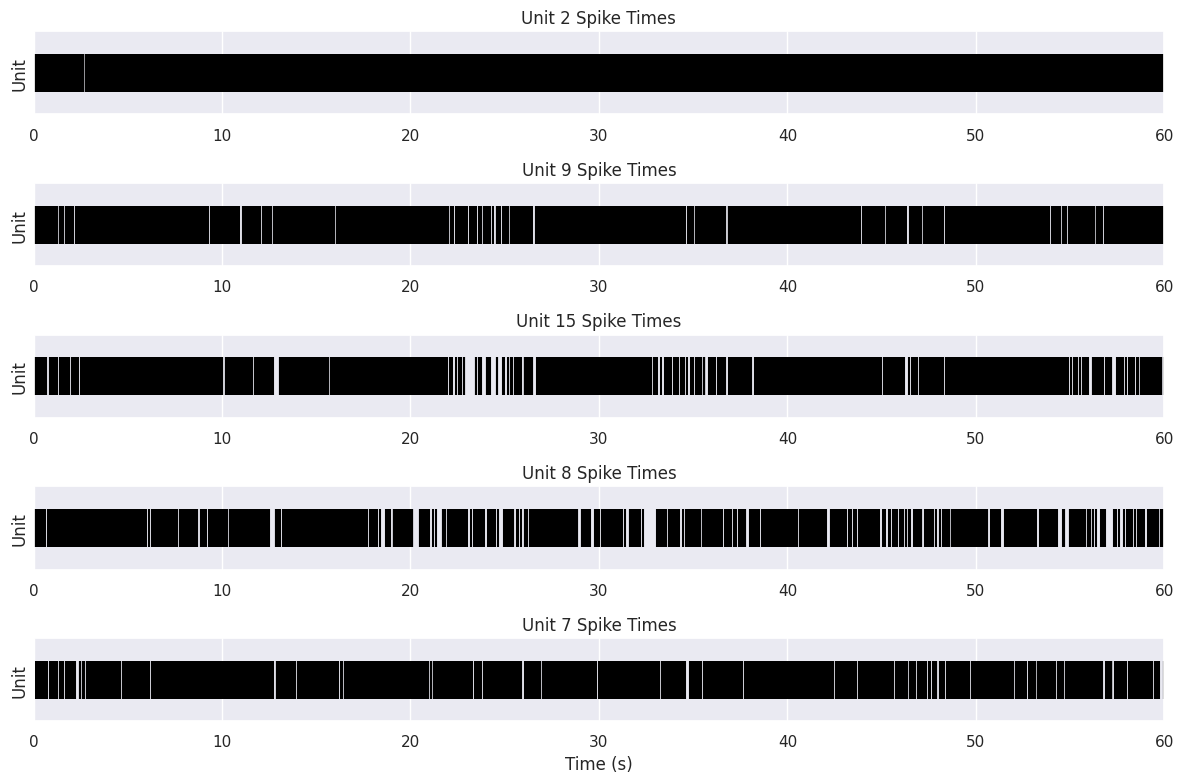

In [8]:
# Select the top 5 most active units
top_units = unit_df.head(5)['unit_id'].values

# Create a figure to plot spike times
plt.figure(figsize=(12, 8))

# Get the total recording duration from the time series data
total_duration = time_series.data.shape[0] / time_series.rate

# Plot spike times for each unit
for i, unit_id in enumerate(top_units):
    spike_times = get_spike_times(unit_id)
    
    # Create a spike raster plot
    plt.subplot(len(top_units), 1, i+1)
    plt.eventplot(spike_times, lineoffsets=0, linelengths=0.5, color='black')
    
    plt.title(f'Unit {unit_id} Spike Times')
    plt.ylabel('Unit')
    
    # Only add x-label for the bottom plot
    if i == len(top_units) - 1:
        plt.xlabel('Time (s)')
    
    # Limit x-axis for visibility - show first 60 seconds
    plt.xlim(0, min(60, total_duration))
    
    # Remove y-ticks
    plt.yticks([])

plt.tight_layout()

## Spike Rate During Trials

Next, let's analyze how spike rates change during the behavioral trials (laps in the virtual hallway).

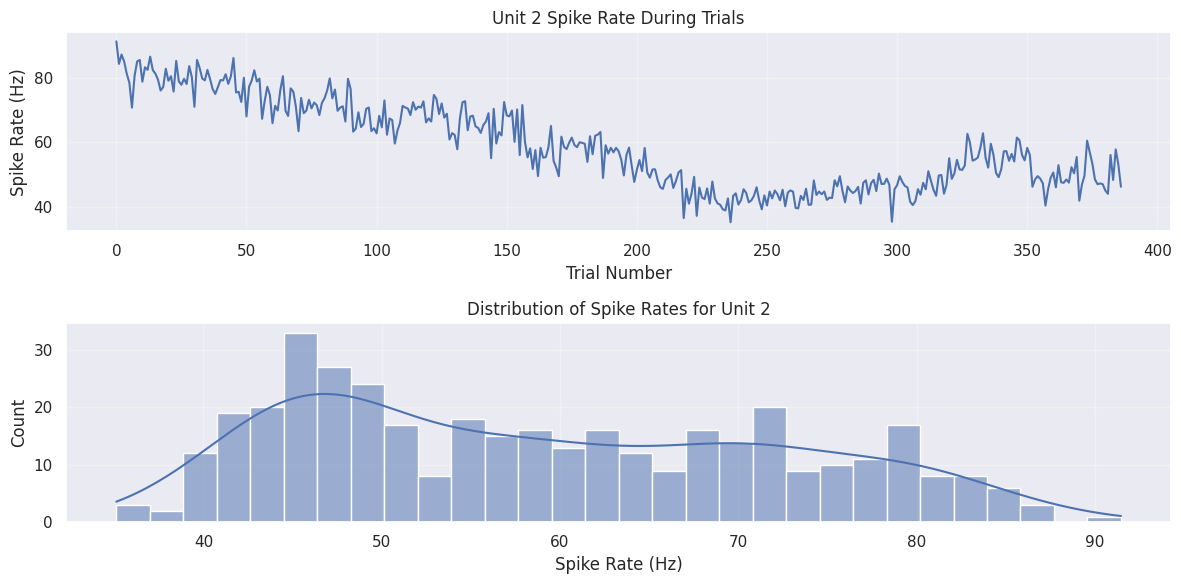

In [9]:
# Select a highly active unit for analysis
unit_id = top_units[0]  # Using the most active unit
spike_times = get_spike_times(unit_id)

# Calculate spikes per trial
spikes_in_trials = []
for _, trial in trials_df.iterrows():
    start_time = trial['start_time']
    stop_time = trial['stop_time']
    
    # Count spikes in this trial
    trial_spikes = np.sum((spike_times >= start_time) & (spike_times <= stop_time))
    
    # Calculate spike rate (spikes per second)
    duration = stop_time - start_time
    spike_rate = trial_spikes / duration if duration > 0 else 0
    
    spikes_in_trials.append({
        'trial_id': len(spikes_in_trials),
        'spikes': trial_spikes,
        'duration': duration,
        'spike_rate': spike_rate
    })

# Convert to DataFrame
trial_spikes_df = pd.DataFrame(spikes_in_trials)

# Plot spike rate across trials
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(trial_spikes_df['trial_id'], trial_spikes_df['spike_rate'])
plt.title(f'Unit {unit_id} Spike Rate During Trials')
plt.xlabel('Trial Number')
plt.ylabel('Spike Rate (Hz)')
plt.grid(True, alpha=0.3)

# Plot histogram of spike rates
plt.subplot(2, 1, 2)
sns.histplot(trial_spikes_df['spike_rate'], bins=30, kde=True)
plt.title(f'Distribution of Spike Rates for Unit {unit_id}')
plt.xlabel('Spike Rate (Hz)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()

## Neural Activity Correlation Across Units

Let's analyze how the activity of different units correlates with each other. We'll create a cross-correlation matrix of spike counts across trials.

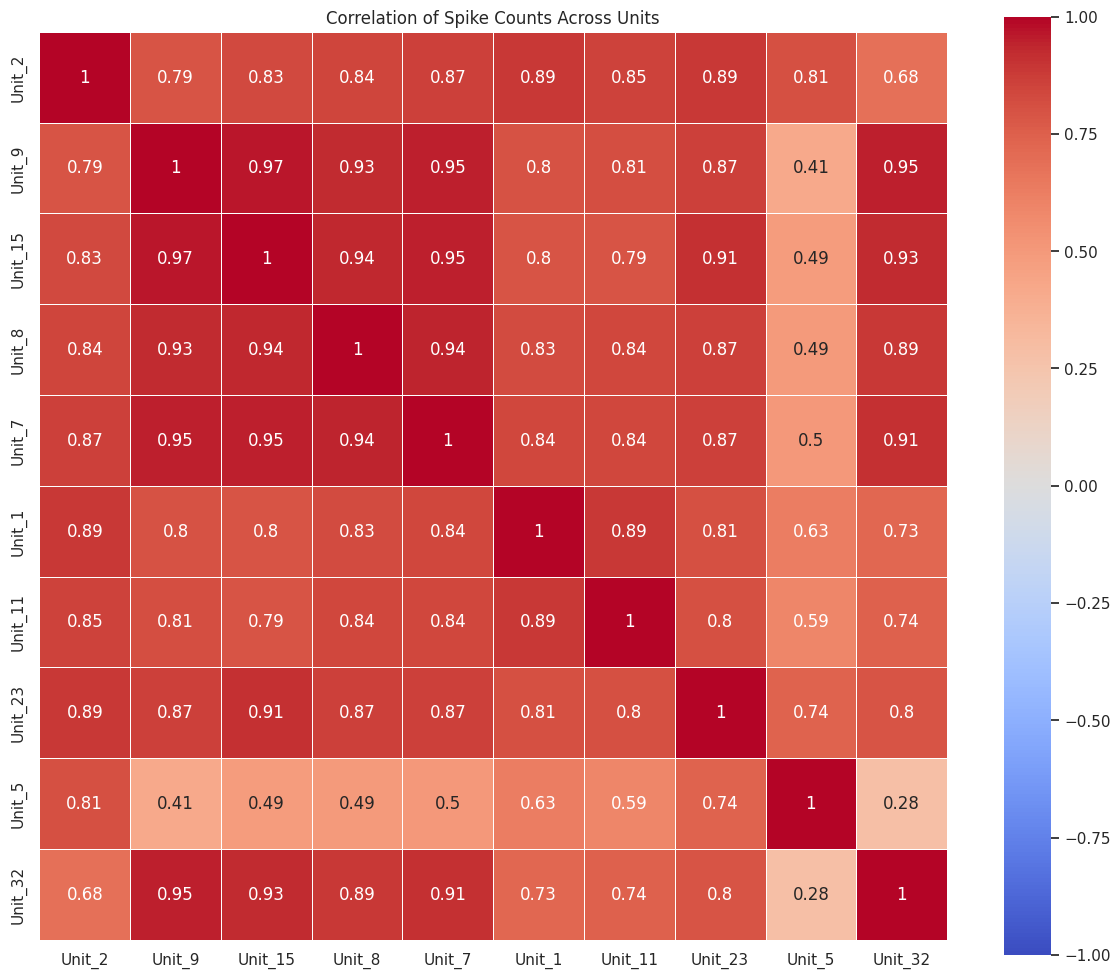

In [10]:
# Calculate spike counts per trial for multiple units
def get_trial_spike_counts(unit_id):
    spike_times = get_spike_times(unit_id)
    counts = []
    
    for _, trial in trials_df.iterrows():
        # Count spikes in this trial
        trial_spikes = np.sum((spike_times >= trial['start_time']) & 
                             (spike_times <= trial['stop_time']))
        counts.append(trial_spikes)
    
    return counts

# Select the top 10 most active units
units_to_analyze = unit_df.head(10)['unit_id'].values

# Create a DataFrame with spike counts per trial for each unit
spike_counts_per_trial = {}
for unit_id in units_to_analyze:
    spike_counts_per_trial[f'Unit_{unit_id}'] = get_trial_spike_counts(unit_id)

spike_count_df = pd.DataFrame(spike_counts_per_trial)

# Calculate correlation matrix
corr_matrix = spike_count_df.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            square=True, linewidths=.5)
plt.title('Correlation of Spike Counts Across Units')
plt.tight_layout()

## Visualizing Unit Activity Over Time

Let's create a more comprehensive visualization of unit activity over time, binning spikes into time windows to create a heatmap of activity.

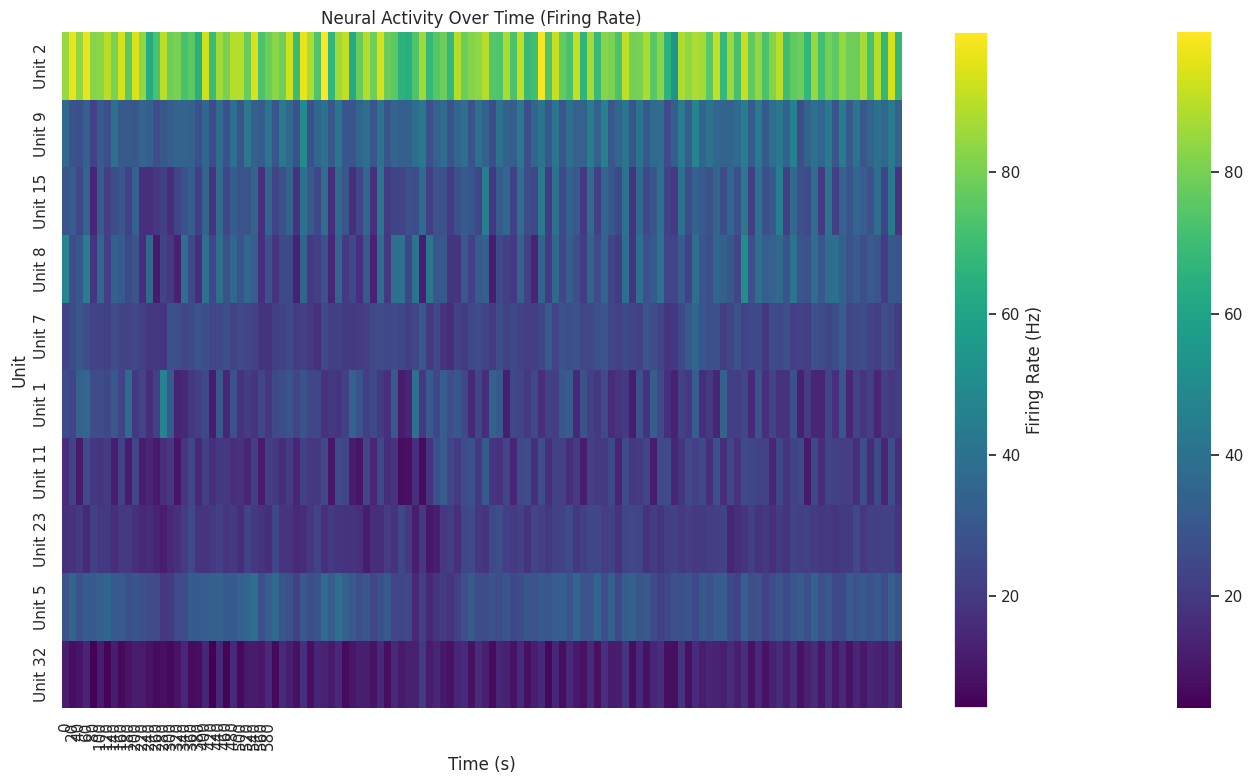

In [11]:
# Select the top 10 most active units
units_to_plot = unit_df.head(10)['unit_id'].values

# Define time bins (5-second bins, up to 10 minutes)
bin_size = 5  # seconds
max_time = min(600, total_duration)  # 10 minutes or total duration if shorter
bins = np.arange(0, max_time + bin_size, bin_size)

# Create a matrix of spike counts (units × time bins)
activity_matrix = np.zeros((len(units_to_plot), len(bins)-1))

for i, unit_id in enumerate(units_to_plot):
    spike_times = get_spike_times(unit_id)
    
    # Filter spikes within our time range
    valid_spikes = spike_times[spike_times <= max_time]
    
    # Count spikes in each bin
    counts, _ = np.histogram(valid_spikes, bins=bins)
    activity_matrix[i, :] = counts

# Normalize by bin size to get firing rates (Hz)
activity_matrix = activity_matrix / bin_size

# Create a heatmap
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(activity_matrix, cmap='viridis', 
                     xticklabels=np.arange(0, max_time, bin_size*4),  # Label every 4th bin
                     yticklabels=[f'Unit {unit_id}' for unit_id in units_to_plot])
plt.title('Neural Activity Over Time (Firing Rate)')
plt.xlabel('Time (s)')
plt.ylabel('Unit')
cbar = plt.colorbar(heatmap.collections[0])  # Use the mappable from heatmap
cbar.set_label('Firing Rate (Hz)')
plt.tight_layout()

## Relationship Between Trial Duration and Neural Activity

Finally, let's explore if there's a relationship between trial duration and neural firing rates.

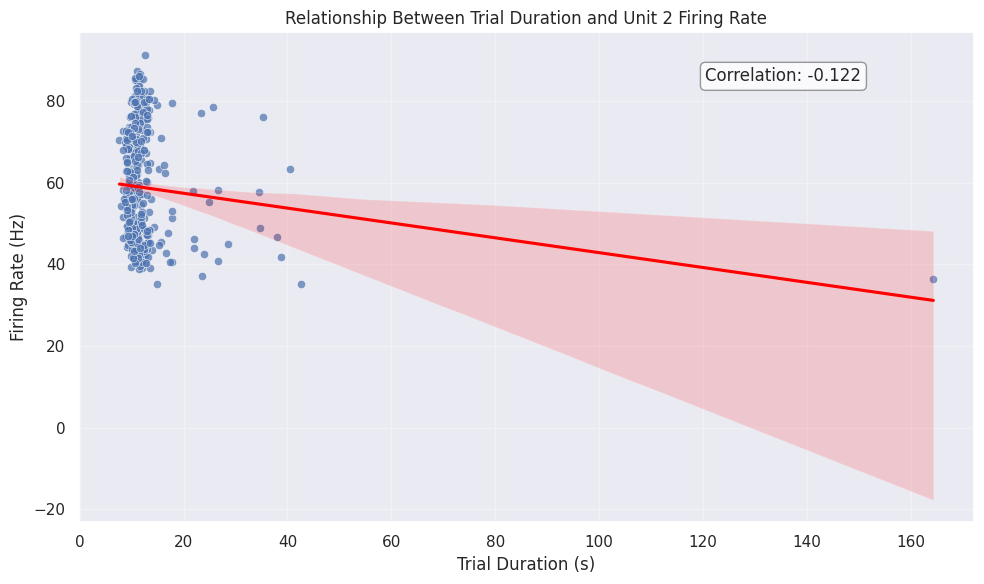

In [12]:
# Select the unit with the most spikes
unit_id = unit_df.iloc[0]['unit_id']

# Create a DataFrame combining trial information with spike rates
combined_df = pd.DataFrame({
    'trial_id': range(len(trials_df)),
    'duration': trials_df['duration'].values,
    'spike_rate': trial_spikes_df['spike_rate'].values
})

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration', y='spike_rate', data=combined_df, alpha=0.7)

# Add regression line
sns.regplot(x='duration', y='spike_rate', data=combined_df, scatter=False, 
            line_kws={'color': 'red'})

plt.title(f'Relationship Between Trial Duration and Unit {unit_id} Firing Rate')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Firing Rate (Hz)')
plt.grid(True, alpha=0.3)

# Calculate and display correlation
correlation = combined_df['duration'].corr(combined_df['spike_rate'])
plt.annotate(f'Correlation: {correlation:.3f}', 
             xy=(0.7, 0.9), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()

## Explore this NWB File in Neurosift

For a more interactive exploration of this dataset, you can use Neurosift, an online viewer for NWB files.

View this file in Neurosift: [https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/ce525828-8534-4b56-9e47-d2a34d1aa897/download/&dandisetId=001375&dandisetVersion=0.250406.1855](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/ce525828-8534-4b56-9e47-d2a34d1aa897/download/&dandisetId=001375&dandisetVersion=0.250406.1855)

## Summary and Future Directions

In this notebook, we've explored the structure and content of Dandiset 001375, "Septum GABA disruption with DREADDs". We've examined:

1. **Dataset Organization**: The Dandiset contains three NWB files with recordings from two subjects during a virtual hallway task.

2. **Data Structure**: Each NWB file contains raw electrophysiology data, sorted spike times, electrode information, and behavioral trial data.

3. **Neural Activity**: We analyzed spike patterns of individual units, their correlations, and their relationship to behavioral trials.

4. **Electrode Configuration**: We visualized the spatial arrangement of recording electrodes across two shanks in the hippocampus and cortex.

### Key Observations:

- The dataset contains high-density electrophysiological recordings from 256 channels across multiple brain regions.
- Neural units show varied activity patterns during behavioral trials.
- There appears to be correlation between some units' activity, suggesting potential functional relationships.

### Future Analysis Directions:

1. **Comparative Analysis**: Compare neural activity between the two subjects and across the different recording sessions.

2. **DREADD Effects**: Analyze how DREADD-mediated suppression of septal GABAergic neurons affects hippocampal and neocortical activity patterns.

3. **Behavioral Correlations**: Further analyze the relationship between neural activity and behavioral metrics during the virtual hallway task.

4. **Advanced Analyses**: Implement more sophisticated analyses such as:
   - Local field potential (LFP) analysis
   - Cross-frequency coupling
   - Spatial coding properties of hippocampal units
   - Network dynamics and information flow between brain regions

This initial exploration provides a foundation for more detailed analyses of how disrupting septal GABAergic activity affects neural circuits in the hippocampus and neocortex.